# Input Driven HMM

This notebook is a simple example of an HMM with exogenous inputs.  The inputs modulate the probability of discrete state transitions via a multiclass logistic regression. Let $z_t \in \{1, \ldots, K\}$ denote the discrete latent state at time $t$ and $u_t \in \mathbb{R}^U$ be the exogenous input at time~$t$.  The transition probability is given by,

$$
\begin{align}
\Pr(z_t = k \mid z_{t-1} = j, u_t) = 
\frac{\exp\{\log P_{j,k} + w_k^\mathsf{T} u_t\}}
{\sum_{k'=1}^K \exp\{\log P_{j,k'} + w_{k'}^\mathsf{T} u_t\}}.
\end{align}
$$

The parameters of the transition model are $P \in \mathbb{R}_+^{K \times K}$, a baseline set of (unnormalized) transition weights, and $W \in \mathbb{R}^{K \times U}$, a set of input weights. 

## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
import seaborn as sns
from ssm.util import one_hot, find_permutation

%matplotlib inline

npr.seed(0)
sns.set(palette="colorblind")

C:\Miniconda3\envs\glm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Create an Input Driven HMM
SSM is designed to be modular, so that the user can easily mix and match different types of transitions and observations.  
We create an input-driven HMM with the following line:  
```python
true_hmm = ssm.HMM(num_states, obs_dim, input_dim, 
               observations="categorical", observation_kwargs=dict(C=num_categories),
               transitions="inputdriven")
```

Let's look at what each of the arguments do. The first three arguments specify the number of states, and the dimensionality of the observations and inputs.

**Setting the observation model**  
For this example, we have set `observations="categorical"`, which means each observation will take on one of a discrete set of values, i.e $y_t \in \{1, \ldots, C \}$. 
For categorical observations, the observations are drawn from a multinomial distribution, with parameters depending on the current state. Assuming $z_t = k$,the observations are a vector $y \in \mathbb{R}^D$, where $y_i \sim \text{mult} (\lambda_{k,i})$, where $\lambda_{k,i}$ is the multinomal parameter associated with coordinate $i$ of the observations in state $k$. Note that each observation variable is independent from the others.

For categorical observations, we also specify the number of discrete observations possible (in this case 3). We do this by creating a dictionary where the keys are the keyword arguments which we want to pass to the observation model. For categorical observations, there is just one keyword argument, `C`, which specifies the number of categories. This is set using `observation_kwargs=dict(C=num_categories)`. 

The observations keyword argument should be one of : `"gaussian", "poisson" "studentst", "exponential", "bernoulli", "autoregressive", "robust_autoregressive"`.
**NOTE:**
Setting the observations as "autoregressive" means that each observation will be dependent on the prior observation, as well as on the input (if the input is nonzero). By constrast, the standard "inputdriven" transitions are not affected by previous observations or directly by the inputs.

**Setting the transition model**  
In order to create an HMM with exogenous inputs, we set ```transitions="inputdriven"```. This means that the baseline transition matrix $P$ is modified according to a Generalized Linear Model, as described at the top of the page.

SSM support many transition models, set by keyword argument to the constructor of the class. The keyword argument should be one of: `"standard", "sticky", "inputdriven", "recurrent", "recurrent_only", "rbf_recurrent", "nn_recurrent".` We're working on creating standalone documentation to describe these in more detail. For most users, the stationary and input driven transition classes should suffice.


**Creating inputs and sampling**  
After creating our HMM object, we create an input array called `inpt` which is simply a jittered sine wave. We also increase the transition weights so that it will be clear (for demonstration purposes) that the input is changing the transition probabilities. In this case, we will actually increase the weights such that the transitions appear almost deterministic.

In [92]:
# Set the parameters of the HMM
time_bins = 1000 # number of time bins
num_states = 3    # number of discrete states
obs_dim = 1    # data dimension
input_dim = 11    # input dimension
num_categories = 3    # number of output types/categories

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, input_dim, 
               observations="categorical", observation_kwargs=dict(C=num_categories),
               transitions="inputdriven")

# Optionally, turn up the input weights to exaggerate the effect
true_hmm.transitions.Ws *= 1

# Create an exogenous input
inpt = np.sin(2 * np.pi * np.arange(time_bins) / 50)[:, None] + 1e-1 * npr.randn(time_bins, input_dim)
#inpt = np.concatenate((inpt, np.ones((inpt.shape[0], 1))), axis=1)
print(inpt.shape)

# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins, input=inpt)

# Compute the true log probability of the data, summing out the discrete states
true_lp = true_hmm.log_probability(obs, inputs=inpt)

# By default, SSM returns categorical observations as a list of lists.
# We convert to a 1D array for plotting.
obs_flat = np.array([x[0] for x in obs])

print(np.exp(true_hmm.transitions.Ws))

(1000, 11)
[[2.63187918 1.9066589  0.45458712 1.31524641 1.03811889 1.16558032
  0.7285371  1.87242937 0.37125123 0.54910745 0.59783964]
 [2.14129187 1.07676256 0.67789247 2.40812807 4.68732081 3.17069985
  0.99654597 1.69886394 0.26053803 2.96420978 0.5427574 ]
 [2.36535842 0.17920154 0.63635113 5.37445452 1.65916024 0.81440278
  2.06031707 1.20143849 2.58432522 2.71663821 2.76152022]]


C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


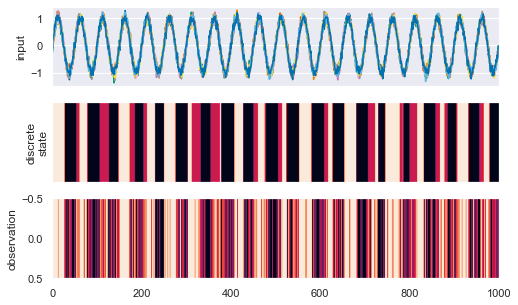

In [93]:
# Plot the data
plt.figure(figsize=(8, 5))

plt.subplot(311)
plt.plot(inpt)
plt.xticks([])
plt.xlim(0, time_bins)
plt.ylabel("input")

plt.subplot(312)
plt.imshow(true_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bins)
plt.ylabel("discrete\nstate")
plt.yticks([])

# Create Cmap for visualizing categorical observations
plt.subplot(313)
plt.imshow(obs_flat[None,:], aspect="auto", )
plt.xlim(0, time_bins)
plt.ylabel("observation")
plt.grid(b=None)
plt.show()

### 2.1 Exercise: EM for the input-driven HMM
There are a few good references that derive the EM algorithm for the case of a vanilla HMM (e.g Machine Learning and Pattern Recognition, by Chris Bishop, and [this tutorial](https://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf) by Lawrence Rabiner. How should the EM updates change for the case of input-driven HMMs?

## 3. Fit an input-driven HMM to data
Below, we'll show to fit an input-driven HMM from data. We'll treat the samples generated above as a dataset, and try to learn the appropriate HMM parameters from this dataset. 

We create a new HMM object here, with the same parameters as the HMM in Section 1: 
```python
hmm = ssm.HMM(num_states, obs_dim, input_dim, 
          observations="categorical", observation_kwargs=dict(C=num_categories),
          transitions="inputdriven")
```

We fit the dataset simply by calling the `fit` method:
```python
hmm_lps = hmm.fit(obs, inputs=inpt, method="em", num_em_iters=N_iters)
```
Here, the variable `hmm_lps` will be set to a list of log-probabilities at each step of the EM-algorithm, which we'll use to check convergence.

In [94]:
# Now create a new HMM and fit it to the data with EM
N_iters = 1000
hmm = ssm.HMM(num_states, obs_dim, input_dim, 
          observations="categorical", observation_kwargs=dict(C=num_categories),
          transitions="inputdriven", transition_kwargs=dict(alpha=2, l2_penalty=1e-4, kappa=0))

# Fit
hmm_lps = hmm.fit(obs, inputs=inpt, method="em", num_iters=N_iters)

LP: -799.6: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.71it/s]


### 3.1 Permute the latent states, check convergence
As in the vanilla-HMM notebook, we need to find a permutation of the latent states from our new hmm such that they match the states from the true HMM above. SSM accomplishes this with two function calls: first, we call `find_permutation(true_states, inferred_states)` which returns a list of indexes into states. 

Then, we call `hmm.permute(permuation)` with the results of our first function call. Finally, we set `inferred_states` to be the underlying states we predict given the data. 

Below, we plot the results of the `fit` function in order to check convergence of the EM algorithm. We see that the log-probability from the EM algorithm approaches the true log-probability of the data (which we have stored as `lp_true`).

In [95]:
# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(true_states, hmm.most_likely_states(obs, input=inpt)))
inferred_states = hmm.most_likely_states(obs, input=inpt)

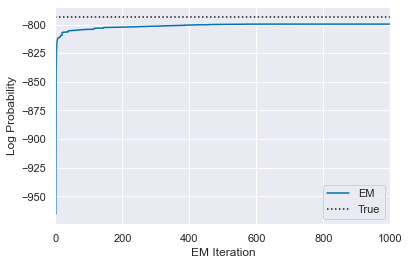

In [96]:
# Plot the log probabilities of the true and fit models
plt.plot(hmm_lps, label="EM")
plt.plot([0, N_iters], true_lp * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, N_iters)
plt.ylabel("Log Probability")
plt.show()

### 3.3 Exercise: Change the Fitting Method
As an experiment, try fitting the same dataset using another fitting method. The two other fitting methods supported for HMMs are "sgd" and "adam", which you can set by passing `method="sgd"` and `method="adam"` respectively. For these methods, you'll probably need to increase the number of iteratations to around 1000 or so.

After fitting with a different method, re-run the two cells above to generate a plot. How does the convergence of these other methods converge to EM?

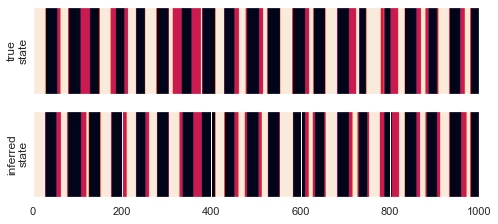

In [97]:
# Plot the true and inferred states
plt.figure(figsize=(8, 3.5))

plt.subplot(211)
plt.imshow(true_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bins)
plt.ylabel("true\nstate")
plt.yticks([])

plt.subplot(212)
plt.imshow(inferred_states[None, :], aspect="auto")
plt.xlim(0, time_bins)
plt.ylabel("inferred\nstate")
plt.yticks([])
plt.show()

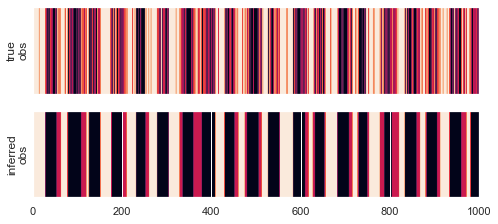

In [98]:
# Plot the true and inferred obs
plt.figure(figsize=(8, 3.5))

plt.subplot(211)
plt.imshow(obs[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bins)
plt.ylabel("true\nobs")
plt.yticks([])

plt.subplot(212)
plt.imshow(inferred_states[None, :], aspect="auto")
plt.xlim(0, time_bins)
plt.ylabel("inferred\nobs")
plt.yticks([])
plt.show()

## 4. Visualize the Learned Parameters
After calling `fit`, our new HMM object will have parameters updated according to the dataset. We can get a sense of whether we successfully learned these parameters by comparing them to the _true_ parameters which generated the data. 

Below, we plot the baseline log transition probabilities (the log of the state-transition matrix) as well as the input weights $w$. 

C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  
C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
C:\Miniconda3\envs\glm\lib\site-p

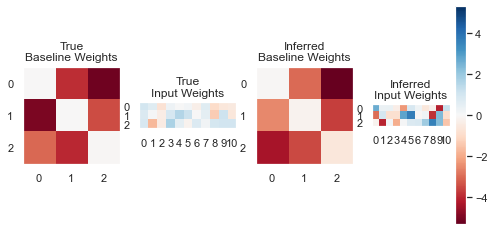

In [99]:
# Plot the true and inferred input effects
plt.figure(figsize=(8, 4))

vlim = max(abs(true_hmm.transitions.log_Ps).max(),
           abs(true_hmm.transitions.Ws).max(),
           abs(hmm.transitions.log_Ps).max(),
           abs(hmm.transitions.Ws).max())

plt.subplot(141)
plt.imshow(true_hmm.transitions.log_Ps, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(num_states))
plt.yticks(np.arange(num_states))
plt.title("True\nBaseline Weights")
plt.grid(b=None)


plt.subplot(142)
plt.imshow(true_hmm.transitions.Ws, vmin=-vlim, vmax=vlim, cmap="RdBu")#, aspect=num_states/input_dim)
plt.xticks(np.arange(input_dim))
plt.yticks(np.arange(num_states))
plt.title("True\nInput Weights")
plt.grid(b=None)


plt.subplot(143)
plt.imshow(hmm.transitions.log_Ps, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(num_states))
plt.yticks(np.arange(num_states))
plt.title("Inferred\nBaseline Weights")
plt.grid(b=None)


plt.subplot(144)
plt.imshow(hmm.transitions.Ws, vmin=-vlim, vmax=vlim, cmap="RdBu")#, aspect=num_states/input_dim)
plt.xticks(np.arange(input_dim))
plt.yticks(np.arange(num_states))
plt.title("Inferred\nInput Weights")
plt.grid(b=None)
plt.colorbar()
plt.show()

C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  import sys
C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
C:\Miniconda3\envs\glm\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]


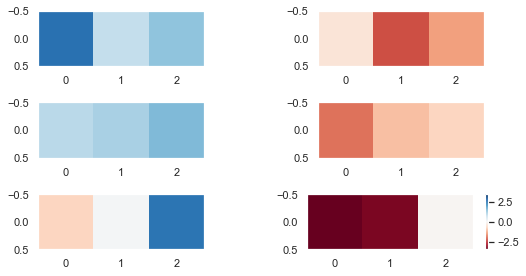

In [100]:
plt.figure(figsize=(8, 4))
vlim = max(abs(true_hmm.observations.params).max(),
           abs(hmm.observations.params).max())
for i in range(num_states):
    plt.subplot(num_states,2,i*2+1)
    plt.imshow(true_hmm.observations.params[i], vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
    plt.grid(b=None)
    
    plt.subplot(num_states,2,i*2+2)
    plt.imshow(hmm.observations.params[i], vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
    plt.grid(b=None)
    
plt.colorbar()
plt.tight_layout()
plt.show()